**Author: Guillermo Raya Garcia**<br>
**NIU: 1568864**<br>
**Universitat Autònoma de Barcelona**
# Real Vs Fake Job Postings: An analysis

__[Link to our dataset](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction)__.

### 1. EDA (exploratory data analysis)
**Preguntes:**
* Quants atributs té la vostra base de dades?
    * _**Resposta:** La nostra base de dades té 18 atributs._
* Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)
    * _**Resposta:** Els tipus d'atributs que tenim són els següents:_

|| Attribute | Data type | Attribute description |
|:--| :-: | :-: | :-- |
|0|'job_id'| int | Row number |
|1|'title'| str | Name of the job offered |
|2|'location'| str | Location on which the job takes place, comprised of Country, State and City|
|3|'department'| str | Department of the offered job |
|4|'salary_range'| float| Salary range of the offered job |
|5|'company_profile'| str | Brief overview of the company |
|6|'description'| str | Description of the offered job |
|7|'requirements'| str | Requirements for the applicants to the job |
|8|'benefits'|float| Benefits included in the offer |
|9|'telecommuting'|int| Availability |
|10|'has_company_logo'|int| Existence and availability of a company logo |
|11|'has_questions'|int| True if screening questions are present. |
|12|'employment_type'|str| Type of employment (e.g.:'Full-time','Part-time', 'Minijob',etc.) |
|13|'required_experience'|str| Required experience for applicants |
|14|'required_education'|float| Required education for applicants |
|15|'industry'|float| Industry of the job offered |
|16|'function'|str| Function of the job offer |
|17|'fraudulent'|int| Fraudulent: 1 if yes, otherwise 0 |

* Com es el target, quantes categories diferents existeixen?
    * _**Resposta:** El nostre target és `'fraudulent'`._
    
* Podeu veure alguna correlació entre X i y?
    * _**Resposta:** Per intuició, podem assumir que, segurament, les ofertes de treball fraudulentes tindràn algunes característiques en comú (a les seves descripcions, per exemple), motiu pel qual podem respondre que probablement sí, hi hagi correlació entre `X` (variables explicatives) i `y`(variable objectiu)._
    
* Estan balancejades les etiquetes (distribució similar entre categories)? Creus que pot afectar a la classificació la seva distribució?
    * _**Resposta:** No, no estan gens balancejades. Hi ha molt pocs casos fraudulents, i això pot esbiaixar la classificació (un classificador que digui "no fraudulent" per a qualsevol oferta de treball tindrà una bona accuracy, i això és inadmissible)._

### 2. Preprocessing (normalitzation, outlier removal, feature selection...)
**Preguntes:**
* Estàn les dades normalitzades? Caldria fer-ho?
    * _**Resposta:** No, les dades no estan normalitzades: alguns dels atributs que sospitem que seran més importants són str. Pensem que serà convenient normalitzar aquestes dades fent servir una vectorització TfIdf._
* En cas que les normalitzeu, quin tipus de normalització será més adient per les vostres dades?
    * _**Resposta:** Com hem esmentat a l'apartat anterior, aplicarem TfIdf als atributs de texte que creiem més rellevants (`'description'` i `company_profile`)._

In [1]:
# First of all, some imports:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset
dataset = load_dataset('fake_job_postings.csv')
values = dataset.values
labels = dataset.columns.values
#values.shape[0] #Total number of rows: 17880
#values.shape[1] #Total number of columns: 18

#dataset #To previsualize the dataset
#Auxiliary function to make cool charts.
def chartMe(content,colnames,rownames,precision=9,pre="", extra=""):
    #Making the rows of the chart
    chart=[]
    for i,valuesRow in enumerate(content):
        newRow=[str(pre+" "+rownames[i]+" "+extra)]
        newRow.extend([valuesRow])
        chart.append(newRow)
        
    #Setting up the precision, as requested by function call
    pd.set_option('precision', precision)
    seriousChart=pd.DataFrame(chart, columns=colnames).style.hide_index()
    pd.reset_option('precision')
    
    return seriousChart

#Example: to chart the content of the first row of values
#chartMe(content=values[1],colnames=["Attribute","Value"],rownames=labels)

In [2]:
#Data preprocessing:
#Let's remove the first attribute from our data, since it only numbers our rows and gives us no useful information.
dataset=dataset.drop(columns=('job_id'))

#And since we will mainly be working with the description attribute, we want to remove all instances that have "nan" on it.
dataset=dataset.dropna(axis=0,subset=['description'])
dataset=dataset.dropna(axis=0,subset=['company_profile'])


#Let's recalculate 'values' and 'labels' with the recently applied changes.
values = dataset.values
labels = dataset.columns.values

#Let's set apart the X (input data, or explicative variables) from the y (target variable).
X=values[:,0:16]
y=values[:,-1:]

#We'll split our data into a Training set and a Test set 
#    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#
#We will use K-fold cross-validation later down the road, this is just to get started.
#    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Since many important fields in this dataset are comprised solely of text, we will need to process them in some way so that we can compare them. And for that, we'll use scikit's tools for text feature extraction.

#Taking a look at the documentation here:
#    https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
#we choose to start by running a TfIdf vectorisation on the 'description' attributes, in order to try out our tools.


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(min_df=0.05, stop_words='english')
tfidf_vectorizer= TfidfVectorizer(min_df=0.05, stop_words='english')
X_t_desc = vectorizer.fit_transform(X_train[:,5])
X_tfidf_desc = tfidf_vectorizer.fit_transform(X_train[:,5])
#X_t_desc # This is the matrix that we get from count vectorizing the description attribute from X_train
#X_tfidf_desc # This is the matrix that we get from vectorizing with TfIdf the description attribute from X_train
#len(vectorizer.get_feature_names_out()) # This is the number of different words found in the countvectorisation.
#tfidf_vectorizer.get_feature_names_out() # These are the words we found with TfIdf vectorisation. When we start analyzing other texts, we'll be looking for the presence and frequency of these words.
#tfidf_vectorizer.vocabulary_.get('website') # ← This command gets us the position of a certain word in our vocabulary

In [3]:
# This next function will apply count vectorisation to a given string.
# Input:
    # · text: string wanted to be transformed using countvectorization.
# Output:
    # Matrix with the result of the countvectorization. Can be transformed into array (for readable results) using ".toarray()"
def vecCountTrans (text):
    return(vectorizer.transform([text]))
def vecCountTrans_array (text):
    return(vectorizer.transform([text]).toarray())

def vecTfidfTrans (text):
    return(tfidf_vectorizer.transform([text]))
def vecTfidfTrans_array (text):
    return(tfidf_vectorizer.transform([text]).toarray())
# ↓ And here's the result of vectorizing a new sentence of my choosing using the two vectorizing methods
#vecCountTrans_array(X_train[0][5])
#vecTfidfTrans_array(X_train[0][5])

In [4]:
# This next function will apply vecCountTrans to our X_train and X_test sets.
# Input:
    # · myArray: Array containing a column that will be transformed using vecCountTrans
    # · colNumber: The index (int) of the column that is desired to be transformed using vecCountTrans
# Output:
    # · newCol: Array containing the vectorisations of the elements in the chosen column of the given ndarray.
def vecCountTrans_column(myArray,colNumber):
    newCol=np.array([])
    for row in range(myArray.shape[0]):
        newCol=np.append(newCol,vecCountTrans(myArray[row,colNumber]))
    return(newCol)

# This other function will apply the previous function and append the resulting array onto the provided array, as a last column.
# Input:
    # · myArray: Array containing a column that will be transformed using vecCountTrans
    # · colNumber: The index (int) of the column that is desired to be transformed using vecCountTrans
# Output:
    # · myNewArray: Array containing the same as myArray, but having the result of vecCountTrans as a last column
def append_vecCountTrans_column(myArray,colNumber):
    nC=vecCountTrans_column(myArray,colNumber)
    nC=np.array([nC]).transpose()
    myNewArray=np.append(myArray,nC,axis=1)
    return(myNewArray)

def vecCountTrans_niceArray(myArray,colNumber):
    niceArray=np.array([])
    for row in range(myArray.shape[0]):
        newInstance=vecCountTrans_array(myArray[row,colNumber])[0]
        niceArray=np.append(niceArray,newInstance)
    return(niceArray.reshape((myArray.shape[0],len(vectorizer.get_feature_names_out()))))



def vecTfidfTrans_column(myArray,colNumber):
    newCol=np.array([])
    for row in range(myArray.shape[0]):
        newCol=np.append(newCol,vecTfidfTrans(myArray[row,colNumber]))
    return(newCol)

def append_vecTfidfTrans_column(myArray,colNumber):
    nC=vecTfidfTrans_column(myArray,colNumber)
    nC=np.array([nC]).transpose()
    myNewArray=np.append(myArray,nC,axis=1)
    return(myNewArray)

def vecTfidfTrans_niceArray(myArray,colNumber):
    niceArray=np.array([])
    for row in range(myArray.shape[0]):
        newInstance=vecTfidfTrans_array(myArray[row,colNumber])[0]
        niceArray=np.append(niceArray,newInstance)
    return(niceArray.reshape((myArray.shape[0],len(tfidf_vectorizer.get_feature_names_out()))))

In [5]:
X_train_vct_desc=vecTfidfTrans_niceArray(X_train,5)
X_test_vct_desc=vecTfidfTrans_niceArray(X_test,5)

X_train_vct_comProf=vecTfidfTrans_niceArray(X_train,4)
X_test_vct_comProf=vecTfidfTrans_niceArray(X_test,4)

X_train_vct_descAndComProf=np.concatenate((X_train_vct_desc,X_train_vct_comProf),axis=1)
X_test_vct_descAndComProf=np.concatenate((X_test_vct_desc,X_test_vct_comProf),axis=1)

flat_y_train=y_train.flatten().astype('int')
flat_y_test=y_test.flatten().astype('int')

In [26]:
X_train_vct_descAndComProf[0].shape

(682,)

### 3. Model Selection
**Preguntes:**
* Quins models heu considerat?
    * _**Resposta:** He escollit els models `logistic regression`, `SVM` (amb kernels `linear` i `rbf`), `perceptron` i `MLP` (MultiLayer Perceptron). Tots aquests mètodes els provaré amb les vectoritzacions dels atributs `description`, i de `company_profile`._
* Quin creieu que serà el més precís?
    * _**Resposta:** Suposo que el més precís serà el `perceptron`, amb un cost computacional més elevat._
* Quin serà el més ràpid?
    * _**Resposta:** Sospito que els més ràpids seran el `SVM` amb kernel tipus `linear` i el `logistic regression`, per la seva relativa simplicitat._

In [6]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression as LogReg
LR = LogReg(random_state=0).fit(X_train_vct_descAndComProf, flat_y_train)
LRscore_descAndComProf=LR.score(X_test_vct_descAndComProf,flat_y_test)
#print ("Percentage of correct classification of  Logistic model,  training with 66% of the data: ",LRscore_descAndComProf*100,"%")

In [7]:
#SVM model (linear kernel)
from sklearn import svm
svc_linear = svm.SVC(C=10.0, kernel='linear', probability=True).fit(X_train_vct_descAndComProf, flat_y_train)
SVCscore_linear_descAndCompProf=svc_linear.score(X_test_vct_descAndComProf, flat_y_test)
#print ("Percentage of correct classification of  SVM model (linear kernel),  training with 66% of the data: ",SVCscore_linear_descAndCompProf*100,"%")

In [8]:
#SVM model (rbf kernel)
from sklearn import svm
svc_rbf = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True).fit(X_train_vct_descAndComProf, flat_y_train)
SVCscore_rbf_descAndCompProf=svc_rbf.score(X_test_vct_descAndComProf, flat_y_test)
#print ("Percentage of correct classification of  SVM model (rbf kernel),  training with 66% of the data: ",SVCscore_descAndCompProf*100,"%")

In [9]:
#Perceptron model
from sklearn.linear_model import Perceptron
perceptron = Perceptron(tol=1e-3)
perceptron.fit(X_train_vct_descAndComProf, flat_y_train)
PerceptronScore_descAndCompProf=perceptron.score(X_test_vct_descAndComProf, flat_y_test)
#print ("Percentage of correct classification of  perceptron model,  training with 66% of the data: ",PerceptronScore_descAndCompProf*100,"%")

Percentage of correct classification of  perceptron model,  training with 66% of the data:  99.70887918486171 %


In [28]:
#MLP model
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(682,682,100,50, 2), random_state=1)
mlp.fit(X_train_vct_descAndComProf, flat_y_train)
mlpScore_descAndCompProf=mlp.score(X_test_vct_descAndComProf, flat_y_test)
print ("Percentage of correct classification of  MLP model,  training with 66% of the data: ",mlpScore_descAndCompProf*100,"%")

Percentage of correct classification of  MLP model,  training with 66% of the data:  99.77126221667706 %


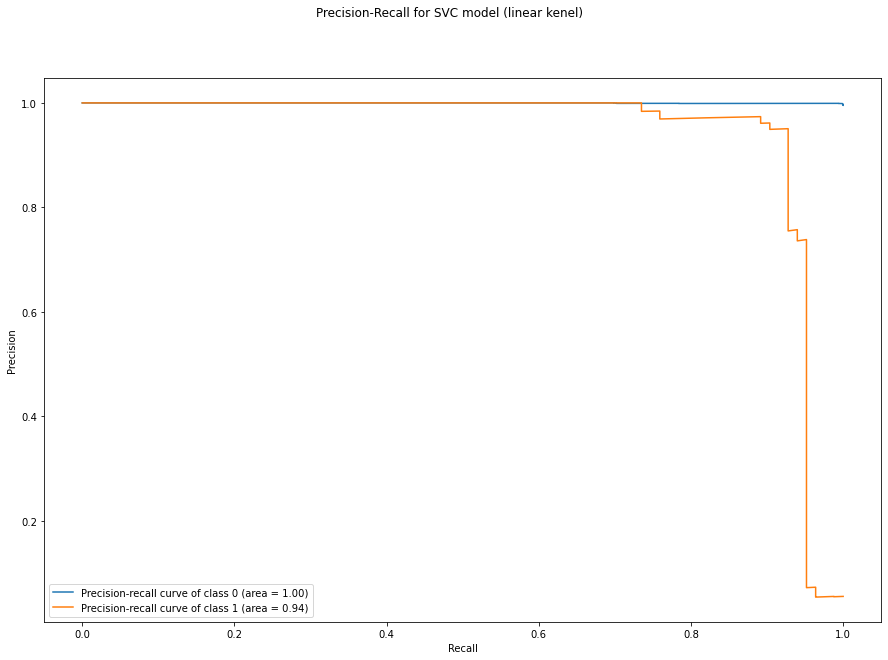

In [44]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

probs = svc_linear.predict_proba(X_test_vct_descAndComProf)
n_classes=2

# Compute Precision-Recall and plot curve for SVC model
precision = {}
recall = {}
average_precision = {}
plt.figure(figsize=(15,10))
plt.suptitle('Precision-Recall for SVC model (linear kenel)')

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(flat_y_test == i, probs[:, i])
    average_precision[i] = average_precision_score(flat_y_test == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

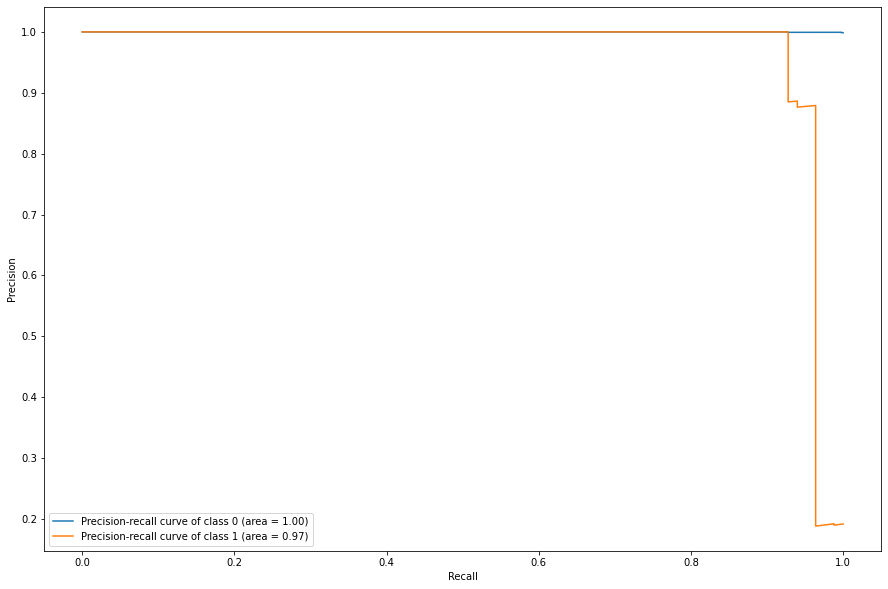

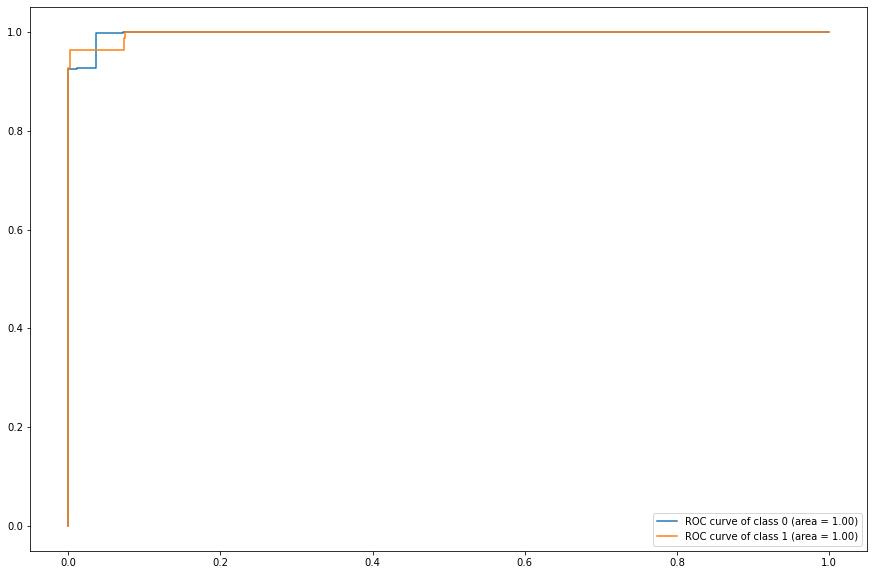

In [11]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

probs = svc_rbf.predict_proba(X_test_vct_descAndComProf)
n_classes=2

# Compute Precision-Recall and plot curve for SVC model
precision = {}
recall = {}
average_precision = {}
plt.figure(figsize=(15,10))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(flat_y_test == i, probs[:, i])
    average_precision[i] = average_precision_score(flat_y_test == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(flat_y_test == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure(figsize=(15,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

### 4. Crossvalidation
**Preguntes:**
* Per què és important cross-validar els resultats?
    * _**Resposta:** Per tal d'entrenar i posar a prova els models d'una forma robusta, que eviti resultats excessivament optimistes fruit de l'atzar._
* Separa la base de dades en el conjunt de train-test. Com de fiables serán els resultats obtinguts? En quins casos serà més fiable, si tenim moltes dades d'entrenament o poques?
    * _**Resposta:** Els resultats no seran tan fiables com fent una crossvalidació. Seràn més fiables quantes més dades d'entrenament tinguem._
* Quin tipus de K-fold heu escollit? Quants conjunts heu seleccionat (quina k)?
    * _**Resposta:** He escollit `k=7`, ja que he anat fent proves i el resultat m'ha semblat raonable._

In [12]:
#Crossvalidation: Precision and Recall scores
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
myK=7
#LogReg
cv_scores_lr = cross_validate(LR, X_train_vct_descAndComProf, flat_y_train, cv=myK, scoring=scoring)
#SVM (linear)
cv_scores_SVM_lin = cross_validate(svc_linear, X_train_vct_descAndComProf, flat_y_train, cv=myK, scoring=scoring)
#SVM (rbf)
cv_scores_SVM_rbf = cross_validate(svc_rbf, X_train_vct_descAndComProf, flat_y_train, cv=myK, scoring=scoring)
#Perceptron
cv_scores_perceptron = cross_validate(perceptron, X_train_vct_descAndComProf, flat_y_train, cv=myK, scoring=scoring)

In [14]:
def chartMe(content,colnames,rownames,precision=9,pre="", extra=""):
    #Making the rows of the chart
    chart=[]
    for i,valuesRow in enumerate(content):
        newRow=[str(pre+" "+rownames[i]+" "+extra)]
        try:
            newRow.extend(valuesRow)
        except:
            newRow.append(valuesRow)
        chart.append(newRow)
        
    #Setting up the precision, as requested by function call
    pd.set_option('precision', precision)
    seriousChart=pd.DataFrame(chart, columns=colnames).style.hide_index()
    pd.reset_option('precision')
    
    return seriousChart

In [23]:
scores_names=[cv_scores_lr,cv_scores_SVM_lin,cv_scores_SVM_rbf,cv_scores_perceptron]
seriousContent=[]
for name in scores_names:
    seriousRow=[]
    for e in name:
        seriousRow.append(str(np.around(np.average(name[e]),decimals=4)))    
    seriousContent.append(seriousRow)
seriousColnames=['Model','fit_time average','score_time average','test_precision_macro average','test_precision_macro average']
seriousRownames=['Logistic Regression','SVM (linear kernel)','SVM (rbf kernel)','Perceptron']
seriousChart=chartMe(content=seriousContent,colnames=seriousColnames,rownames=seriousRownames)
display(seriousChart)

Model,fit_time average,score_time average,test_precision_macro average,test_precision_macro average
Logistic Regression,0.1829,0.0023,0.9943,0.7194
SVM (linear kernel),6.2681,0.0657,0.9493,0.9555
SVM (rbf kernel),38.8358,1.4222,0.9979,0.898
Perceptron,0.1052,0.0045,0.9555,0.9379
